<span style='background:#FFF8E1; font-size:30px; display:block; border-left:40px solid #FFECB3; padding-left:40px;'>
<b>
    STEPWISE METEOSCREENING DB
</b>
</span>

**notebook version: `2.3`** (23 Apr 2023)  
**new in this version:** added time resolution checks after resampling to 30 minutes and after data download

# **ABOUT THIS NOTEBOOK**

In this notebook, the raw data are downloaded from the database, quality-screened, resampled and then uploaded to the database using the [StepwiseMeteoScreeningDb](https://gitlab.ethz.ch/diive/diive/-/blob/main/diive/pkgs/qaqc/meteoscreening.py) class in [diive](https://gitlab.ethz.ch/diive/diive).  

**Here is an overview of what is done in this notebook**:
- (1) **USER SETTINGS**: First, we specify some general settings for the site and variable
- (2) **AUTO-SETTINGS**: With this info, some settings are set automatically
- (3) **DOWNLOAD DATA FROM DATABASE WITH `dbc-influxdb`**: Then original raw data are downloaded from the database. This step uses the Python module  
`dbc-influxdb` to download the data.
- (4) **METEOSCREENING WITH `diive`**: The downloaded data is then quality-screened using the Python library `diive`. The screening is done on the *high-resolution* data,  
i.e., in the original time resolution of the raw data. After the screening, data are resampled to 30MIN time resolution, the same resolution that we typically use for the fluxes.
- (5) **UPLOAD DATA TO THE DATABASE WITH `dbc-influxdb`**: The screened and resampled data are then uploaded to the database.

For more info about Stepwise MeteoScreeningDb, see notebook **Info - StepwiseMeteoScreeningDb**.

---

# **USER SETTINGS** (please adjust)

## Site

In [1]:
SITE = 'ch-dav'
SITE_LAT = 46.81524
SITE_LON = 9.85597

## Variables to screen
- Specify variables as shown in the database
- `FIELDS`: Variables are called FIELDS in the database. InfluxDB stores variable names as '_field'. You can specify multiple fields, given as a list e.g. `['TA_NABEL_T1_35_1', 'TA_T1_20_1]`
- `MEASUREMENTS`: Only **one** measurement allowed. Measurement name that is used to group similar variables together, e.g., `TA` contains all air temperature variables, `SW` are all short-wave radiation measurements and `SWC` all soil water measurements. 

In [2]:
FIELDS = ['SW_IN_NABEL_T1_35_1']
MEASUREMENT = 'SW'

## Time range to screen
- `START`: Screen data starting with this date (the start date itself **IS** included)
- `STOP`: Screen data before this date (the stop date itself **IS NOT** included)

In [3]:
START = '2021-01-01 00:00:01'
STOP = '2024-01-01 00:00:01'

---

# **AUTO-SETTINGS**

## Data settings

In [4]:
DATA_VERSION = 'raw'
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
RESAMPLING_FREQ = '30T'  # During MeteoScreening the screened high-res data will be resampled to this frequency; '30T' = 30-minute time resolution
RESAMPLING_AGG = 'mean'  # The resampling of the high-res data will be done using this aggregation methos; e.g., 'mean'
DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Location of configuration files, needed e.g. for connection to database
# DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'

## Imports

In [5]:
from datetime import datetime
import pkg_resources
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd
from bokeh.plotting import output_notebook, show
output_notebook()
from dbc_influxdb import dbcInflux
from diive.pkgs.qaqc.meteoscreening import StepwiseMeteoScreeningDb
from diive.core.plotting.timeseries import TimeSeries
from diive.core.times.times import DetectFrequency
version_diive = pkg_resources.get_distribution("diive").version
print(f"diive version: v{version_diive}")
version_dbc_influxdb = pkg_resources.get_distribution("dbc_influxdb").version
print(f"dbc-influxdb version: v{version_dbc_influxdb}")

Loading BokehJS ...

C:\Users\holukas\AppData\Local\pypoetry\Cache\virtualenvs\gl-notebooks-MVO4P_O4-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


diive version: v0.53.2
dbc-influxdb version: v0.8.1


## Automatic settings (do not adjust):

In [6]:
BUCKET_RAW=f'{SITE}_raw'  # The 'bucket' where data are stored in the database, e.g., 'ch-lae_raw' contains all raw data for CH-LAE
BUCKET_PROCESSING=f'{SITE}_processing'  # The 'bucket' where data are stored in the database, e.g., 'ch-lae_processing' contains all processed data for CH-LAE
print(f"Bucket containing raw data (source bucket): {BUCKET_RAW}")
print(f"Bucket containing processed data (destination bucket): {BUCKET_PROCESSING}")

Bucket containing raw data (source bucket): ch-dav_raw
Bucket containing processed data (destination bucket): ch-dav_processing


## Connect to database

In [7]:
dbc = dbcInflux(dirconf=DIRCONF)

Reading configuration files was successful.
Connection to database works.


## Check available variables
- Since we are now connected to the database, we can make a quick check if the variable(s) we want to screen are really in the database.  
Below you can show show all available fields in the selected measurement.
- However, if the desired variable(s) are indeed listed here, it does not necessarily mean that they are also available during the  
selected **time period**. This can be the case if the variable(s) for that time period were not uploaded to the database.

In [8]:
# display(dbc.show_fields_in_measurement(bucket=BUCKET_RAW, measurement=MEASUREMENT))

---

# **DOWNLOAD DATA FROM DATABASE WITH `dbc-influxdb`**
- Here the Python library `dbc-influxdb` is used to download data from the database.
- The name of the library means **d**ata**b**ase **c**ommunication using **influxdb**.
- You can find the source code of `dbc-influxdb` [here](https://gitlab.ethz.ch/poet/dbc-influxdb).
- There is no need to adjust the settings here, the variables given earlier (above) are directly used.
- At this point we have already established the connection to the database and stored the connection details in the variable `dbc`.
- Now we can use the method `dbc.download()` to start the data download.

## Download data

In [9]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=BUCKET_RAW,
    measurements=[MEASUREMENT],
    fields=FIELDS,
    start=START,
    stop=STOP,
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)

    variables ['SW_IN_NABEL_T1_35_1'] from measurements ['SW']
    between 2021-01-01 00:00:01 and 2024-01-01 00:00:01
    in data version raw
    with timezone offset to UTC of 1
Downloaded data for 1 variables:
    SW_IN_NABEL_T1_35_1   (1212431 records)     first date: 2021-01-01 00:01:00    last date: 2023-04-23 00:00:00
Fields in measurement SW of bucket ch-dav_raw:
#1  ch-dav_raw  SW  SW_IN_BAK_T1_35_1
#2  ch-dav_raw  SW  SW_IN_NABEL_T1_35_1
#3  ch-dav_raw  SW  SW_IN_T1_35_1
#4  ch-dav_raw  SW  SW_IN_T1_35_2
#5  ch-dav_raw  SW  SW_IN_T2_2.1_1
#6  ch-dav_raw  SW  SW_IN_X_X_X
#7  ch-dav_raw  SW  SW_OUT_T1_35_1
#8  ch-dav_raw  SW  SW_OUT_T1_35_2
#9  ch-dav_raw  SW  SW_OUT_T2_2.1_1
#10  ch-dav_raw  SW  SW_OUT_X_X_X
Found 10 fields in measurement SW of bucket ch-dav_raw.
CPU times: total: 1min 23s
Wall time: 1min 31s


## Check downloaded data
### `dbc` downloads three variables:
- `data_simple`: This is the simplest data download. It contains only the high-resolution variable(s) from the specified measurement. Each variable is in a separate column. Since different variables, can have different time resolutions, the highest time resolution across the variables is used as the index. This means that lower resolution variables will show gaps in the higher resolution timestamp.
- `data_detailed`: This is the most important variable for the MeteoScreening from the database, because it contains not only the high-resolution time series of the variable(s), but also their tags. The tags are important when uploading data to the database. This is a very special format, because data for each variable are stored in a dictionary. A dictionary is a data structure that stores key-value pairs. The key is the variable name (e.g., `TA_NABEL_T1_35_1`) and the value is a complete dataframe that contains the time series of the respective variable and all tags.
- `assigned_measurements`: An auxiliary variable that is useful to check whether the measurement of the variable(s) is correct. In case we are screening air temperatures, the measurement must be `TA`.

#### `data_simple`
- Simply contains the time series of the measured variable(s) in a nice-to-look-at dataframe.

In [10]:
data_simple

,SW_IN_NABEL_T1_35_1
TIMESTAMP_END,
2021-01-01 00:01:00,-0.4
2021-01-01 00:02:00,0.0
2021-01-01 00:03:00,0.0
2021-01-01 00:04:00,0.0
2021-01-01 00:05:00,0.0
...,...
2023-04-22 23:56:00,0.0
2023-04-22 23:57:00,-0.1
2023-04-22 23:58:00,-1.0


#### `data_detailed`
- Dictionary of key-value pairs: the variable name is the key, the respective data (measured time series and tags) are the values

In [11]:
data_detailed

{'SW_IN_NABEL_T1_35_1':                                            config_filetype data_raw_freq data_version       filegroup freq gain hpos raw_units raw_varname repl  units              varname vpos  SW_IN_NABEL_T1_35_1
 TIMESTAMP_END                                                                                                                                                                                        
 2021-01-01 00:01:00  DAV13-RAW-NABEL-201901010000-CSV-1MIN             T          raw  13_meteo_nabel    T    1   T1      W/m²      STRGLO    1  W m-2  SW_IN_NABEL_T1_35_1   35                 -0.4
 2021-01-01 00:02:00  DAV13-RAW-NABEL-201901010000-CSV-1MIN             T          raw  13_meteo_nabel    T    1   T1      W/m²      STRGLO    1  W m-2  SW_IN_NABEL_T1_35_1   35                  0.0
 2021-01-01 00:03:00  DAV13-RAW-NABEL-201901010000-CSV-1MIN             T          raw  13_meteo_nabel    T    1   T1      W/m²      STRGLO    1  W m-2  SW_IN_NABEL_T1_35_1   35    

<br>
Since the output above is not so nice to look at, we loop through the dictionary and display the first and last records for each variable:

In [12]:
for varname, frame in data_detailed.items():
    print(f"{'-' * 40}\nData for {varname}:")
    display(frame)

----------------------------------------
Data for SW_IN_NABEL_T1_35_1:


,config_filetype,data_raw_freq,data_version,filegroup,freq,gain,hpos,raw_units,raw_varname,repl,units,varname,vpos,SW_IN_NABEL_T1_35_1
TIMESTAMP_END,,,,,,,,,,,,,,
2021-01-01 00:01:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,-0.4
2021-01-01 00:02:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,0.0
2021-01-01 00:03:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,0.0
2021-01-01 00:04:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,0.0
2021-01-01 00:05:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-22 23:56:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,0.0
2023-04-22 23:57:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,-0.1
2023-04-22 23:58:00,DAV13-RAW-NABEL-201901010000-CSV-1MIN,T,raw,13_meteo_nabel,T,1,T1,W/m²,STRGLO,1,W m-2,SW_IN_NABEL_T1_35_1,35,-1.0


#### `assigned_measurements`
- Contains the *automatically* detected measurement for the selected variables, useful as check to make sure the variable was properly identified.

In [13]:
assigned_measurements

{'SW_IN_NABEL_T1_35_1': 'SW'}

<br>
It is possible that a variable that we want to screen is not available in the database (oh no). To find out which variable that might be we have this piece of code:

In [14]:
print(f"Data available for: {data_detailed.keys()}\n")
vars_not_available = [v for v in FIELDS if v not in data_detailed.keys()]
print(f"No data available for the following variables: {vars_not_available}")

Data available for: dict_keys(['SW_IN_NABEL_T1_35_1'])

No data available for the following variables: []


## Save downloaded high-res raw data to file (optional)
- If you really want, you can download the full resolution data to a file. This can be useful if you want to do the screening elsewhere.

In [15]:
# data_detailed['TA_NABEL_T1_35_1'].to_csv("mylovelyhorse.csv")

## Plot downloaded high-res data
- Yes, this is indeed a plot of the downloaded full-resolution data.
- Because we have plenty of time and space, each variable gets it's own plot.
- If there is only one variable, then there is only one plot.

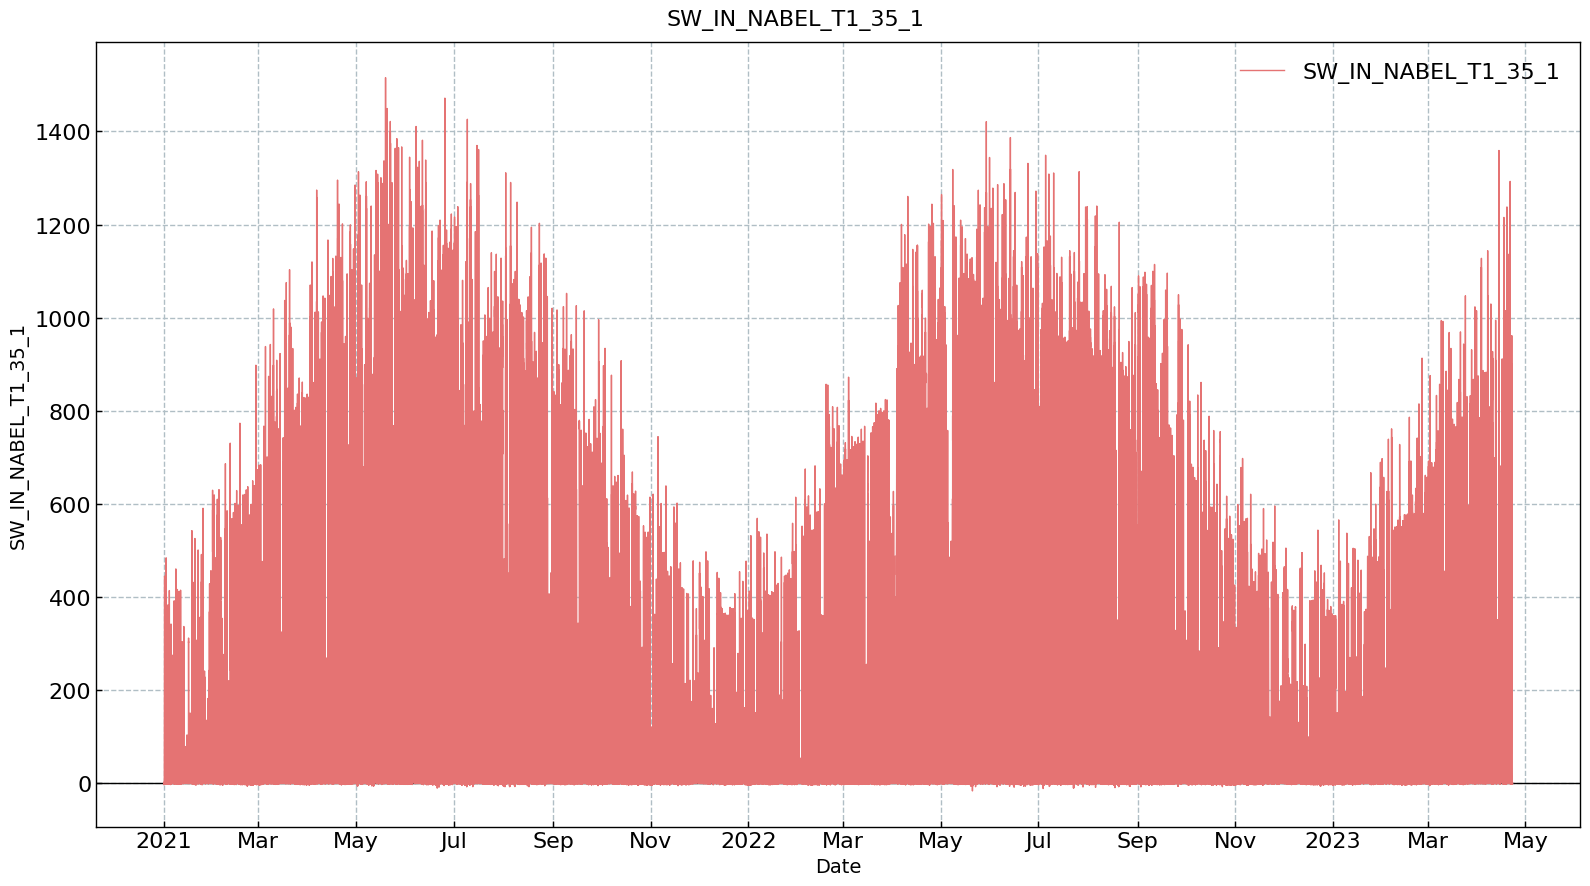

In [16]:
for varname, frame in data_detailed.items():
    # TimeSeries(series=frame[varname]).plot_interactive()
    TimeSeries(series=frame[varname]).plot()

---

# **METEOSCREENING WITH `diive`**

## Start new MeteoScreening session

In [17]:
mscr = StepwiseMeteoScreeningDb(site=SITE,
                                data_detailed=data_detailed,
                                measurement=MEASUREMENT,
                                fields=FIELDS,
                                site_lat=SITE_LAT,
                                site_lon=SITE_LON)

Found 1 unique frequencies across 1212418 records.
Found frequencies:
    Found time resolution 60.0 (seconds) with 1212418 records (100.00% of total records). 
The following frequencies will be used: [60.0] (seconds)


<br>
Now let's take a look at the data that will be screened:

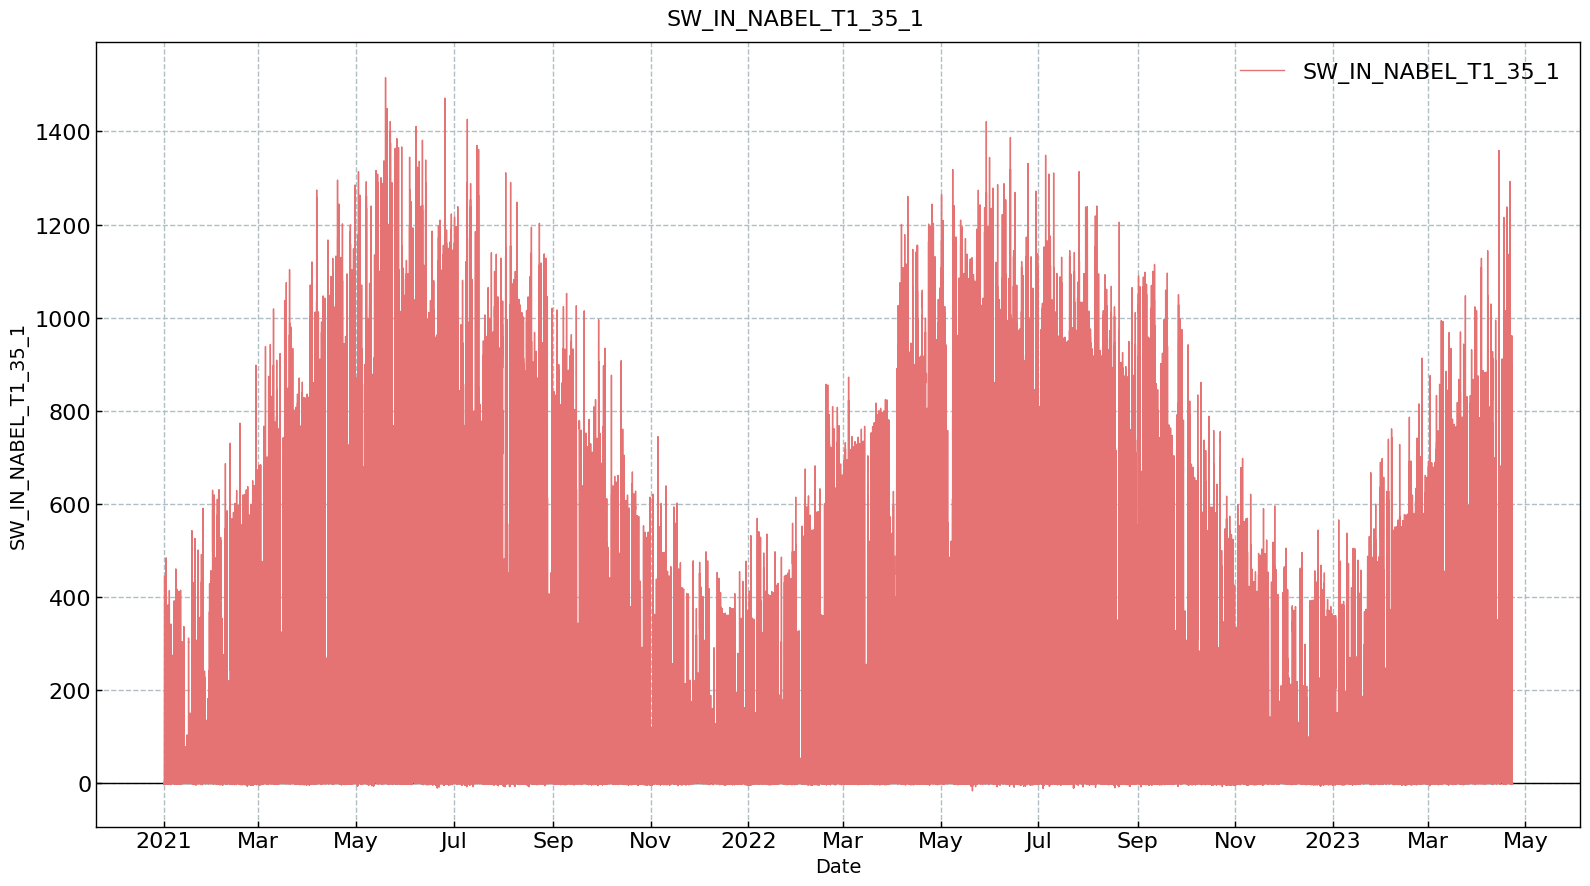

In [18]:
# mscr.showplot_orig(interactive=True)
mscr.showplot_orig()

## **QC FLAGS**: generate quality flags on high-resolution data (if needed)

<span style='background:#FFEBEE; font-size:16px; line-height: 100px; display:block; border-left:40px solid #FFCDD2; padding-left:40px;'>
<p>
    If the plots look good and you think the data do not require any screening, you can skip this section and jump directly to <b>Corrections</b> or <b>Resampling</b>.
</p>
</span>

### **Flag: Missing values test** (always needed)

Must be used for: **-ALL-**  
*Generate flag that indicates missing records in data*

In [19]:
mscr.flag_missingvals_test()



[MissingValues]  ========================================
[MissingValues]  MissingValues
[MissingValues]  ========================================
Generating flag FLAG_SW_IN_NABEL_T1_35_1_MISSING_TEST for variable SW_IN_NABEL_T1_35_1 ...
[MissingValues]  Done.
[MissingValues]  ________________________________________


In [20]:
mscr.addflag()

++Added flag column FLAG_SW_IN_NABEL_T1_35_1_MISSING_TEST to flag data


### **Flag: Outlier detection, z-score over all data** (*flag_outliers_zscore_test*)

Can be used for: **--ALL--**  
This is a general purpose test that can already solve many outlier issues.  
*Identify outliers based on the z-score of records*

In [ ]:
 # mscr.flag_outliers_zscore_test(threshold=3, showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, Local SD** (*flag_outliers_localsd_test*)

Can be used for: **-ALL-**  
*Identify outliers based on the local standard deviation, based on the rolling mean and standard deviation*  
<br>
Parameters:
- `N_SD` ... Number of standard deviations for outliers
- `WINSIZE` ... Number of records used for the rolling time window. If `None` the window size is calculated as 1/20 of data length.

In [ ]:
# N_SD = 1
# WINSIZE = None
# mscr.flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, showplot=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, z-score over all data with IQR** (*flag_outliers_zscoreiqr_test*)

Can be used for: **--ALL--**  
*Identify outliers based on max z-scores in the interquartile range data*

In [ ]:
# mscr.flag_outliers_zscoreiqr_test(factor=1.7, showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, z-score over all data, separate for daytime and nighttime** (*flag_outliers_zscore_dtnt_test*)

Can be used for: **TA**  
*Identify outliers based on the z-score, separately for daytime and nighttime*

In [ ]:
# mscr.flag_outliers_zscore_dtnt_test(threshold=2.5, showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, Seasonal trend decomposition (residuals, IQR, z-score)** (*flag_outliers_stl_riqrz_test*)

Can be used for: **TA**  
*Identify outliers based on seasonal-trend decomposition and z-score calculations*

In [ ]:
# mscr.flag_outliers_stl_riqrz_test(zfactor=2, decompose_downsampling_freq='2H', showplot=True, repeat=False)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, Increments z-score** (*flag_outliers_increments_zcore_test*)

Can be used for: **-ALL-**  
*Identify outliers based on the z-score of record increments*

In [ ]:
# mscr.flag_outliers_increments_zcore_test(threshold=85, showplot=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, Absolute limits** (*flag_outliers_abslim_test*)

Can be used for: **-ALL-**  
*Generate flag that indicates if values in data are outside the specified range*

In [ ]:
# MIN = -20
# MAX = 50
# mscr.flag_outliers_abslim_test(min=MIN, max=MAX, showplot=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, Thymeboost** (*flag_outliers_thymeboost_test*)

Can be used for: **TA**  
*Identify outliers based on [thymeboost](https://github.com/tblume1992/ThymeBoost)*

In [ ]:
# mscr.flag_outliers_thymeboost_test(showplot=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, manual removal** (*flag_manualremoval_test*)

Can be used for: **-ALL-**  
*Generate flag for data points that should be removed*

In [ ]:
# mscr.showplot_cleaned()

In [ ]:
# REMOVE_DATES = [
#     '2022-05-12 17:40:30',
#     # ['2021-08-05', '2021-08-19']
# ]
# mscr.flag_manualremoval_test(remove_dates=REMOVE_DATES, showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, local outlier factor** (*flag_outliers_lof_test*)

Can be used for: **-ALL-**  
*Identify outliers based on the local outlier factor*

In [ ]:
# mscr.flag_outliers_lof_test(n_neighbors=None, contamination='auto', showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

### **Flag: Outlier detection, local outlier factor daytime/nighttime** (*flag_outliers_lof_dtnt_test*)

Can be used for: **-ALL-**  
*Identify outliers based on the local outlier factor, done separately for daytime and nighttime data*

In [ ]:
# mscr.flag_outliers_lof_dtnt_test(n_neighbors=None, contamination='auto', showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

### **QCF**: calculate overall quality flag for high-resolution data

In [21]:
mscr.calc_qcf()

#### Reports

In [22]:
mscr.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable SW_IN_NABEL_T1_35_1.

Number of SW_IN_NABEL_T1_35_1 records before QC: 1212418
+++ FLAG_SW_IN_NABEL_T1_35_1_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 1212418 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_SW_IN_NABEL_T1_35_1_QCF rejected 0 values (+0.00%)      TOTALS: flag 0: 1212418 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)

In total, 0 (0.00%) of the available records were rejected in this step.
INFO Rejected DAYTIME records where QCF flag >= 2
INFO Rejected NIGHTTIME records where QCF flag >= 2


In [ ]:
mscr.report_qcf_series()

In [ ]:
mscr.report_qcf_flags()

#### Plots

In [ ]:
mscr.showplot_qcf_heatmaps(figsize=(18,8))

In [ ]:
mscr.showplot_qcf_timeseries(figsize=(18,8))

---

## **CORRECTIONS**: done on high-resolution data (if needed)

<span style='background:#FFEBEE; font-size:16px; line-height: 100px; display:block; border-left:40px solid #FFCDD2; padding-left:40px;'>
<p>
    Currently only needed for <b>SW, PPFD, RH</b>.
</p>
</span>

### **Correction: Remove radiation zero offset** (*correction_remove_radiation_zero_offset*)
Can be used for: **SW_IN, SW_OUT, PPFD_IN, PPFD_OUT**  
*Remove nighttime offset from all radiation data and set nighttime to zero*



[remove_radiation_zero_offset]  ========================================
[remove_radiation_zero_offset]  remove_radiation_zero_offset
[remove_radiation_zero_offset]  ========================================
Calculating sun altitude in 10T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[remove_radiation_zero_offset]  Done.
[remove_radiation_zero_offset]  ________________________________________


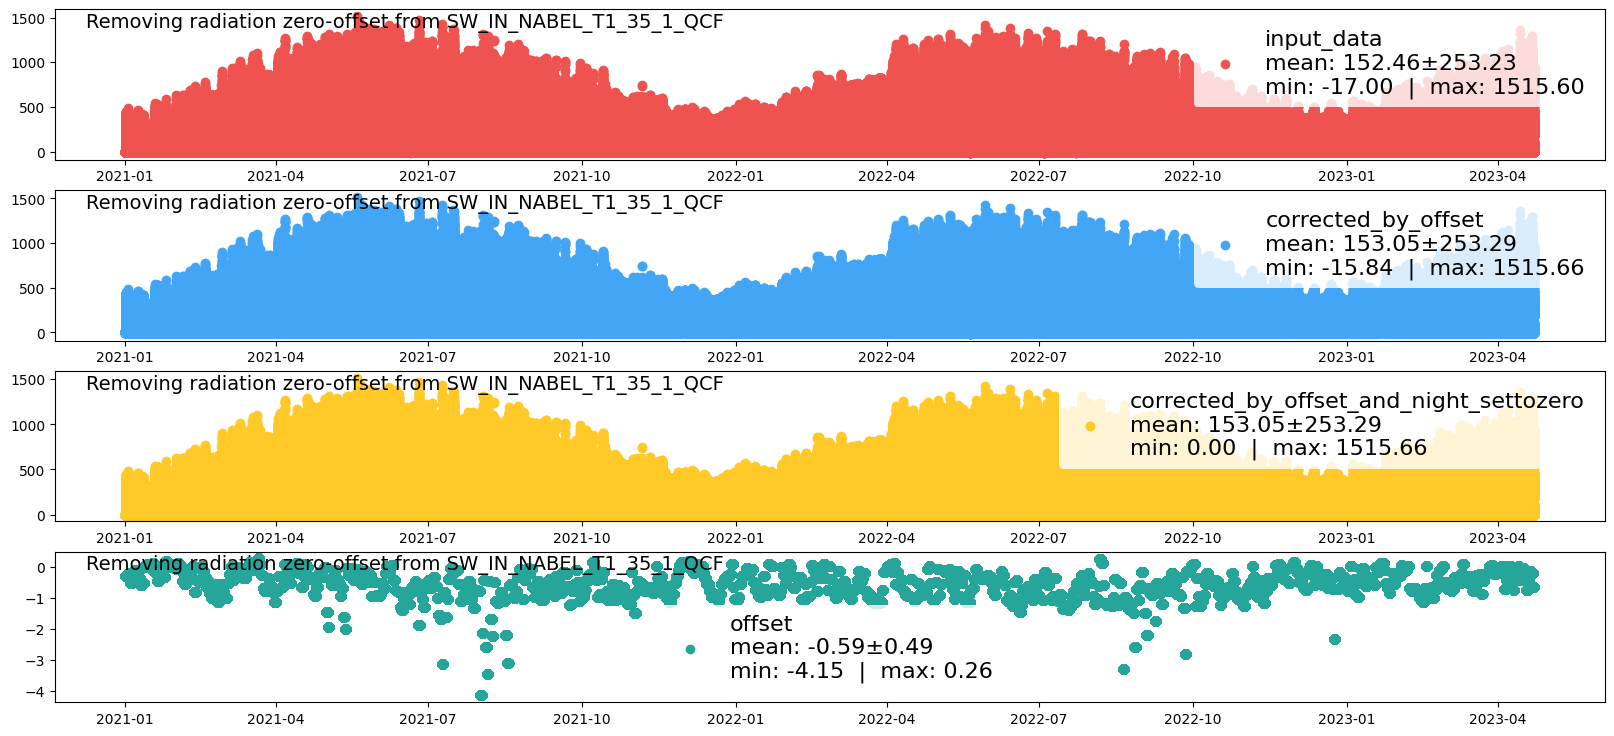

In [23]:
mscr.correction_remove_radiation_zero_offset()

### **Correction: Remove relative humidity offset** (*correction_remove_relativehumidity_offset*)
Can be used for: **RH**  
*Remove relative humidity offset, works for relative humidity data where maximum values should not exceed 100%*  

In [ ]:
# mscr.correction_remove_relativehumidity_offset()

### **Correction: Set to max threshold** (*correction_setto_max_threshold*)
Can be used for: **--ALL--**  
*Set values above threshold to threshold*

In [ ]:
# mscr.correction_setto_max_threshold(threshold=9999)

### **Correction: Set to min threshold** (*correction_setto_min_threshold*)
Can be used for: **--ALL--**  
*Set values below threshold to threshold*

In [ ]:
# mscr.correction_setto_min_threshold(threshold=9999)

---

## **RESAMPLING** <a class="anchor" id="resampling"></a>

### Resample

In [24]:
mscr.resample(to_freqstr=RESAMPLING_FREQ, agg=RESAMPLING_AGG, mincounts_perc=.25)



[resample_series_to_30MIN]  ========================================
[resample_series_to_30MIN]  resample_series_to_30MIN
[resample_series_to_30MIN]  ========================================
Resampling data from T to 30T frequency ...
[resample_series_to_30MIN]  Done.
[resample_series_to_30MIN]  ________________________________________


### Plot original and resampled data

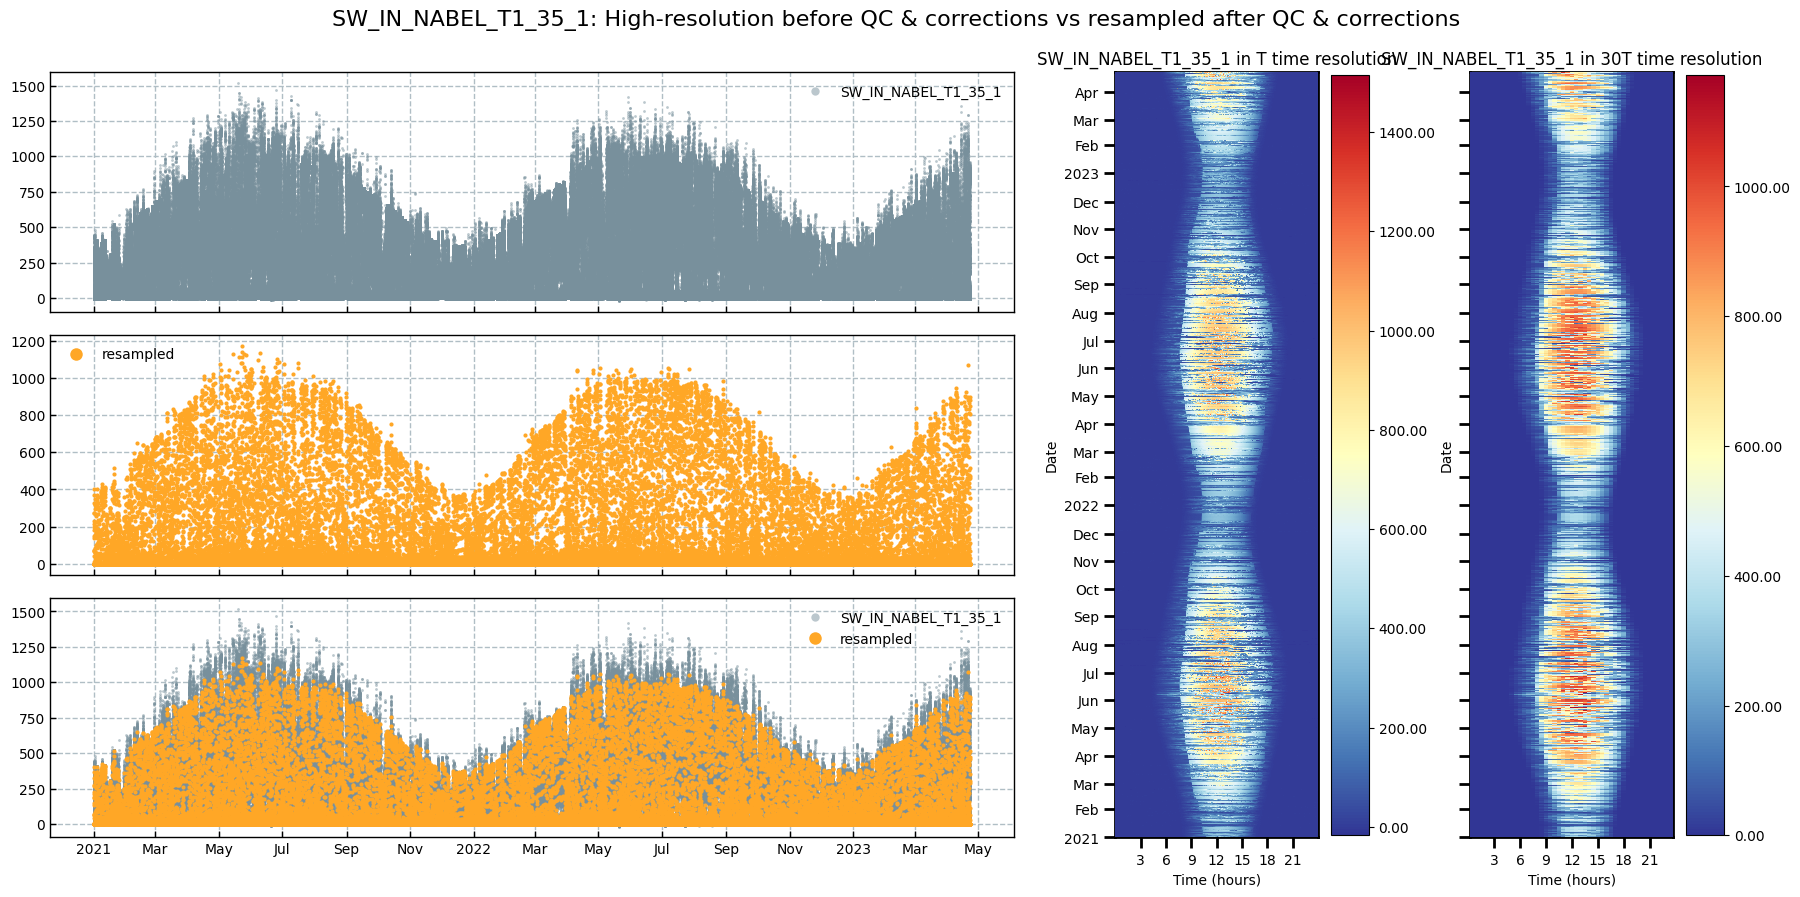

In [25]:
mscr.showplot_resampled()

### Check time resolution of resampled data

<span style='background:#FFF8E1; font-size:14px;'>
    new in notebook v2.3
</span>

In [27]:
for v in mscr.resampled_detailed.keys():   
    print(f"{'-' * 20}\n{v}")
    _checkfreq = DetectFrequency(index=mscr.resampled_detailed[v].index, verbose=True).get()
    if _checkfreq == RESAMPLING_FREQ:
        print(f"TEST PASSED - The resampled variable {v} has a time resolution of {_checkfreq}.")
    else:
        print(f"{'#' * 20}(!)TEST FAILED - The resampled variable {v} does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

--------------------
SW_IN_NABEL_T1_35_1
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30T time resolution with MAXIMUM confidence.
   All approaches yielded the same result:
       from full data = 30T / full data (OK)
       from timedelta = 30T / >99% occurrence (OK)
       from progressive = 30T / data 1000+1000 (OK)

TEST PASSED - The resampled variable SW_IN_NABEL_T1_35_1 has a time resolution of 30T.


---

# **UPLOAD DATA TO THE DATABASE WITH `dbc-influxdb`**

In [28]:
print(f"Data will be uploaded to bucket {BUCKET_PROCESSING}")

Data will be uploaded to bucket ch-dav_processing


In [29]:
for v in mscr.resampled_detailed.keys(): 
    m = assigned_measurements[v]    
    dbc.upload_singlevar(to_bucket=BUCKET_PROCESSING,
                         to_measurement=m,
                         var_df=mscr.resampled_detailed[v],
                         timezone_of_timestamp='UTC+01:00')
    # dbc.upload_singlevar(to_bucket='test', to_measurement=m, var_df=vars_qc_resampled[v], timezone_of_timestamp='UTC+01:00')

Connecting to database ...
--> UPLOAD TO DATABASE BUCKET ch-dav_processing:  ['SW_IN_NABEL_T1_35_1']
Upload finished.


---

# **DATACHECK: DOWNLOAD FROM DATABASE**

In [30]:
dbc = dbcInflux(dirconf=DIRCONF)
# dbc.show_fields_in_measurement(bucket=BUCKET_PROCESSING, measurement='SW')

Reading configuration files was successful.
Connection to database works.


In [31]:
data_simple, data_detailed, assigned_measurements = dbc.download(bucket=BUCKET_PROCESSING,
                                                                 measurements=[MEASUREMENT],
                                                                 fields=FIELDS,
                                                                 start=START,
                                                                 stop=STOP,
                                                                 timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                                                                 data_version='meteoscreening')

    variables ['SW_IN_NABEL_T1_35_1'] from measurements ['SW']
    between 2021-01-01 00:00:01 and 2024-01-01 00:00:01
    in data version meteoscreening
    with timezone offset to UTC of 1
Downloaded data for 1 variables:
    SW_IN_NABEL_T1_35_1   (40416 records)     first date: 2021-01-01 00:30:00    last date: 2023-04-23 00:00:00
Fields in measurement SW of bucket ch-dav_processing:
#1  ch-dav_processing  SW  NIGHT
#2  ch-dav_processing  SW  SW_IN_ERA
#3  ch-dav_processing  SW  SW_IN_F
#4  ch-dav_processing  SW  SW_IN_F_MDS
#5  ch-dav_processing  SW  SW_IN_F_MDS_QC
#6  ch-dav_processing  SW  SW_IN_F_QC
#7  ch-dav_processing  SW  SW_IN_NABEL_T1_35_1
#8  ch-dav_processing  SW  SW_IN_POT
#9  ch-dav_processing  SW  SW_IN_T1_35_2
#10  ch-dav_processing  SW  SW_IN_T2_2.1_1
#11  ch-dav_processing  SW  SW_OUT
Found 11 fields in measurement SW of bucket ch-dav_processing.


In [32]:
data_simple

,SW_IN_NABEL_T1_35_1
TIMESTAMP_END,
2021-01-01 00:30:00,0.0
2021-01-01 01:00:00,0.0
2021-01-01 01:30:00,0.0
2021-01-01 02:00:00,0.0
2021-01-01 02:30:00,0.0
...,...
2023-04-22 22:00:00,0.0
2023-04-22 22:30:00,0.0
2023-04-22 23:00:00,0.0


### Check time resolution of downloaded data

<span style='background:#FFF8E1; font-size:14px;'>
    new in notebook v2.3
</span>

In [33]:
for v in data_detailed.keys():   
    print(f"{'-' * 20}\n{v}")
    _checkfreq = DetectFrequency(index=data_detailed[v].index, verbose=True).get()
    if _checkfreq == RESAMPLING_FREQ:
        print(f"TEST PASSED - The downloaded variable {v} has a time resolution of {_checkfreq}.")
    else:
        print(f"{'#' * 20}(!)TEST FAILED - The downloaded variable {v} does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

--------------------
SW_IN_NABEL_T1_35_1
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30T time resolution with MAXIMUM confidence.
   All approaches yielded the same result:
       from full data = 30T / full data (OK)
       from timedelta = 30T / >99% occurrence (OK)
       from progressive = 30T / data 1000+1000 (OK)

TEST PASSED - The downloaded variable SW_IN_NABEL_T1_35_1 has a time resolution of 30T.


---

# **FINISH**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [34]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-04-23 16:22:54
